# Get Nightlight Data from Google Earth Engine using GEEMap

In [1]:
import ee
import geemap

## Authenticate & Initialize GEE

Requires a [Google Cloud Project](https://console.cloud.google.com/projectcreate) and to enable the [Earth Engine API](https://console.cloud.google.com/apis/api/earthengine.googleapis.com) for the project. Find detailed instructions [here](https://book.geemap.org/chapters/01_introduction.html#earth-engine-authentication).

In [ ]:
# ee.Authenticate()
# errors if I run with gee environment
# https://stackoverflow.com/questions/75666380/attributeerror-module-ipython-utils-traitlets-has-no-attribute-unicode
# run with anaconda base environment

In [2]:
ee.Initialize()

## Create a GEEMap Object

In [3]:
m = geemap.Map(
    center=[-5, 15], 
    zoom=3, 
    basemap = 'Esri.WorldImagery',
    height = 1200
)
m

Map(center=[-5, 15], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

## Add Layers to the Map

In [32]:
# add nightlights median
# https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG
dataset_night = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG') \
                  .filter(ee.Filter.date('2022-01-01', '2023-11-01'))
nighttime = dataset_night.select('avg_rad')
image_night = nighttime.median()
nighttimeVis = {'min': 0.0, 'max': 2.0}
m.addLayer(image_night, nighttimeVis, 'Nighttime')


In [33]:
# add WorldPop population density layer
# https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#description
dataset_pop = ee.ImageCollection('WorldPop/GP/100m/pop') \
                  .filter(ee.Filter.date('2020-01-01', '2020-12-31'))
pop = dataset_pop.select('population')
image_pop = pop.median()
popVis = {
    'min': 0.0, 
    'max': 20.0,
    'palette': ['24126c', '1fff4f', 'd4ff50'],
    'opacity': 0.5
}
m.addLayer(image_pop, popVis, 'Population')


In [11]:
# overlay country boundaries with white borders
countries = ee.FeatureCollection('FAO/GAUL/2015/level0')
# styleParams = {
#   'fillColor': '00000000',
#   'color': 'ffffff',
#   'width': 1.0,
#   'lineType': 'solid'
# }
# style = {'color': 'ffffff82', 'width': 1, 'lineType': 'solid', 'fillColor': 'ffffff00'}
m.addLayer(countries, {}, 'Countries')

# note: this isn't styling the countries correctly
# manually change the country layer to have a transparent fill on the interactive map
# note do not rerun these cells multiple times, seems to freeze the map

In [34]:
# add place names
# https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0
m.add_basemap('CartoDB.VoyagerOnlyLabels')
# m.remove_layer('CartoDB.VoyagerOnlyLabels') # doesn't work

## Import All Sites to Visualize on Map

In [4]:
# read in pg sites
pg_sites_fc = geemap.geojson_to_ee('data/pg/pg_sites.geojson')
cbil_sites_fc = geemap.geojson_to_ee('data/cbil/cbil_sites.geojson')
cluber_sites_fc = geemap.geojson_to_ee('data/cluber/cluber_sites.geojson')

# add to map with unique colors
m.addLayer(cluber_sites_fc, {'color': 'red'}, 'CLUBER Sites')
m.addLayer(cbil_sites_fc, {'color': 'yellow'}, 'CBIL Sites')
m.addLayer(pg_sites_fc, {'color': 'orange'}, 'PG Sites')


## Import Control Sites

Get the control sites for Nigeria and Sierra Leone respectively. 

In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [6]:
# read in excel file
sl_ctrl_df = pd.read_excel(
    'data/pg/SLBU USTDA Site Survey Summary Data.xlsx', 
    sheet_name='Summary Info',
    header=1    
)
# keep certain columns and rows
sl_ctrl_df = sl_ctrl_df.iloc[0:40, 1:10]
# turn this into a geodataframe

# create a geometry column
geometry = [Point(xy) for xy in zip(sl_ctrl_df['Longitude'], sl_ctrl_df['Latitude'])]
# create a geodataframe
sl_ctrl_gdf = gpd.GeoDataFrame(sl_ctrl_df, crs='EPSG:4326', geometry=geometry)
# gdf.head(10)
# remove periods from column names
sl_ctrl_gdf.columns = sl_ctrl_gdf.columns.str.replace('.', '')

# convert the geodataframe to an ee feature collection
sl_ctl_fc = geemap.geopandas_to_ee(sl_ctrl_gdf)

# add the geodataframe to the map in yellow
# m.addLayer(sl_ctl_fc, {'color': 'ffff00'}, 'SL Control Sites')

In [7]:
# read in nigeria control sites
ng_ctrl_df = pd.read_excel(
    'data/pg/NGBU Site Survey Data.xlsx', 
    sheet_name='Sheet1',
    header=1    
)
# keep certain columns and rows
ng_ctrl_df = ng_ctrl_df.iloc[0:11, 1:9]
ng_ctrl_df
# create a geometry column
geometry = [Point(xy) for xy in zip(ng_ctrl_df['Longitude'], ng_ctrl_df['Latitude'])]
# create a geodataframe
ng_ctrl_gdf = gpd.GeoDataFrame(ng_ctrl_df, crs='EPSG:4326', geometry=geometry)
# remove periods from column names
ng_ctrl_gdf.columns = ng_ctrl_gdf.columns.str.replace('.', '')
# convert the geodataframe to an ee feature collection
ng_ctl_fc = geemap.geopandas_to_ee(ng_ctrl_gdf)
# add the geodataframe to the map in yellow
m.addLayer(ng_ctl_fc, {'color': 'ffff00'}, 'NG Control Sites')

In [ ]:
# zoom into Siera Leone
m.centerObject(countries.filter(ee.Filter.eq('ADM0_NAME', 'Sierra Leone')))
m


## Get Nightlight Values for Sierra Leone Sites

In [9]:
import datetime as dt

# read in pg sites as gdf
pg_gdf = gpd.read_file('data/pg/pg_sites.geojson')
# read in cbil sites as gdf
cbil_gdf = gpd.read_file('data/cbil/cbil_sites.geojson')

# pull out just Sierra Leone sites from geodataframes
sl_ctrl_gdf = sl_ctrl_gdf
sl_pg_gdf = pg_gdf[pg_gdf['country'] == 'Sierra Leone']
sl_cbil_gdf = cbil_gdf[cbil_gdf['country'] == 'Sierra Leone']

# add a column to tag where each site is from
sl_ctrl_gdf['site_type'] = 'Control'
sl_pg_gdf['site_type'] = 'PowerGen'
sl_cbil_gdf['site_type'] = 'CBIL'

# add a site name column
sl_ctrl_gdf['site_name'] = sl_ctrl_gdf['Community']
sl_pg_gdf['site_name'] = sl_pg_gdf['site_name']
sl_cbil_gdf['site_name'] = sl_cbil_gdf['site']


# add a date commissioned column
sl_ctrl_gdf['date_commissioned'] = '2030-01-01' # date way in the future
sl_pg_gdf['date_commissioned'] = sl_pg_gdf['date_commissioned']
# convert the metadataprojectcod column to datetime
sl_cbil_gdf['metadataprojectcod'] = pd.to_datetime(sl_cbil_gdf['metadataprojectcod'])
# convert the metadataprojectcod column to string
sl_cbil_gdf['date_commissioned'] = sl_cbil_gdf['metadataprojectcod'].dt.strftime('%Y-%m-%d')

# # check the date_commissioned column of sl_cbil_gdf
# sl_cbil_gdf['date_commissioned']

# export the geodataframes to csv
sl_ctrl_gdf.to_csv('data/sl_ctrl_gdf.csv', index=False)
sl_pg_gdf.to_csv('data/sl_pg_gdf.csv', index=False)
sl_cbil_gdf.to_csv('data/sl_cbil_gdf.csv', index=False)


In [22]:
# filter out Manowa Junction because coordinates are in another country
sl_pg_gdf = sl_pg_gdf[sl_pg_gdf['site_name'] != 'Manowa Junction']

# remove sites from sl_cbil_gdf that are in sl_pg_gdf
sl_cbil_gdf = sl_cbil_gdf[~sl_cbil_gdf['site_name'].isin(sl_pg_gdf['site_name'])]

# remove control sites that are in sl_pg_gdf
sl_ctrl_gdf = sl_ctrl_gdf[~sl_ctrl_gdf['site_name'].isin(sl_pg_gdf['site_name'])]


# keep just relevant columns: date_commissioned, site_name, site_type, geometry
sl_ctrl_gdf = sl_ctrl_gdf[['date_commissioned', 'site_name', 'site_type', 'geometry']]
sl_pg_gdf = sl_pg_gdf[['date_commissioned', 'site_name', 'site_type', 'geometry']]
sl_cbil_gdf = sl_cbil_gdf[['date_commissioned', 'site_name', 'site_type', 'geometry']]


print("Shape of sl_ctrl_gdf is ", sl_ctrl_gdf.shape)
print("Shape of sl_pg_gdf is ", sl_pg_gdf.shape)
print("Shape of sl_cbil_gdf is ", sl_cbil_gdf.shape)


# merge into 1 geodataframe
sl_sites_gdf = pd.concat([sl_ctrl_gdf, sl_pg_gdf, sl_cbil_gdf])
# convert to geodataframe
sl_sites_gdf = gpd.GeoDataFrame(sl_sites_gdf, crs='EPSG:4326', geometry='geometry')

# export to geojson
sl_sites_gdf.to_file('data/sl/sl_sites.geojson', driver='GeoJSON')


Shape of sl_ctrl_gdf is  (39, 4)
Shape of sl_pg_gdf is  (37, 4)
Shape of sl_cbil_gdf is  (10, 4)


## Convert to Earth Engine & Sample Nightlight Values

In [23]:
# rread in geojson as fc
sl_fc = geemap.geojson_to_ee('data/sl/sl_sites.geojson')

In [24]:
# create 1km buffer around each site
sl_fc_buffer = sl_fc.map(lambda f: f.buffer(1000))

In [26]:
# get the nighttime values for each buffer
# https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG
dataset_night = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG') \
                  .filter(ee.Filter.date('2014-01-01', '2024-01-01'))
nighttime_ic = dataset_night.select('avg_rad')
nighttime_ic

# stack image collection into a single image with many bands
nighttime_stack = nighttime_ic.toBands()

nighttime_stack

In [30]:
# get the mean nighttime values for each buffer from the stacked image with reduceRegions
sl_fc = nighttime_stack.reduceRegions(
    collection=sl_fc_buffer, 
    reducer=ee.Reducer.mean(), 
    scale=50
)

# convert to geopandas
sl_gdf = geemap.ee_to_geopandas(sl_fc)

# replace "_avg_rad" in the column names with ""
sl_gdf.columns = sl_gdf.columns.str.replace('_avg_rad', '')

# export to geojson
sl_gdf.to_file('data/sl/sl_sites_nighttime.geojson', driver='GeoJSON')

sl_gdf.shape

(86, 123)

In [31]:
# add viirs dnb nighttime values to the map
nighttime = 

Map(bottom=2766.0, center=[-10.31491928581316, 728.5693359375001], controls=(WidgetControl(options=['position'…

In [35]:
# zoom into Pepel
m.centerObject(sl_fc.filter(ee.Filter.eq('site_name', 'Pepel')))

## Visualize Results

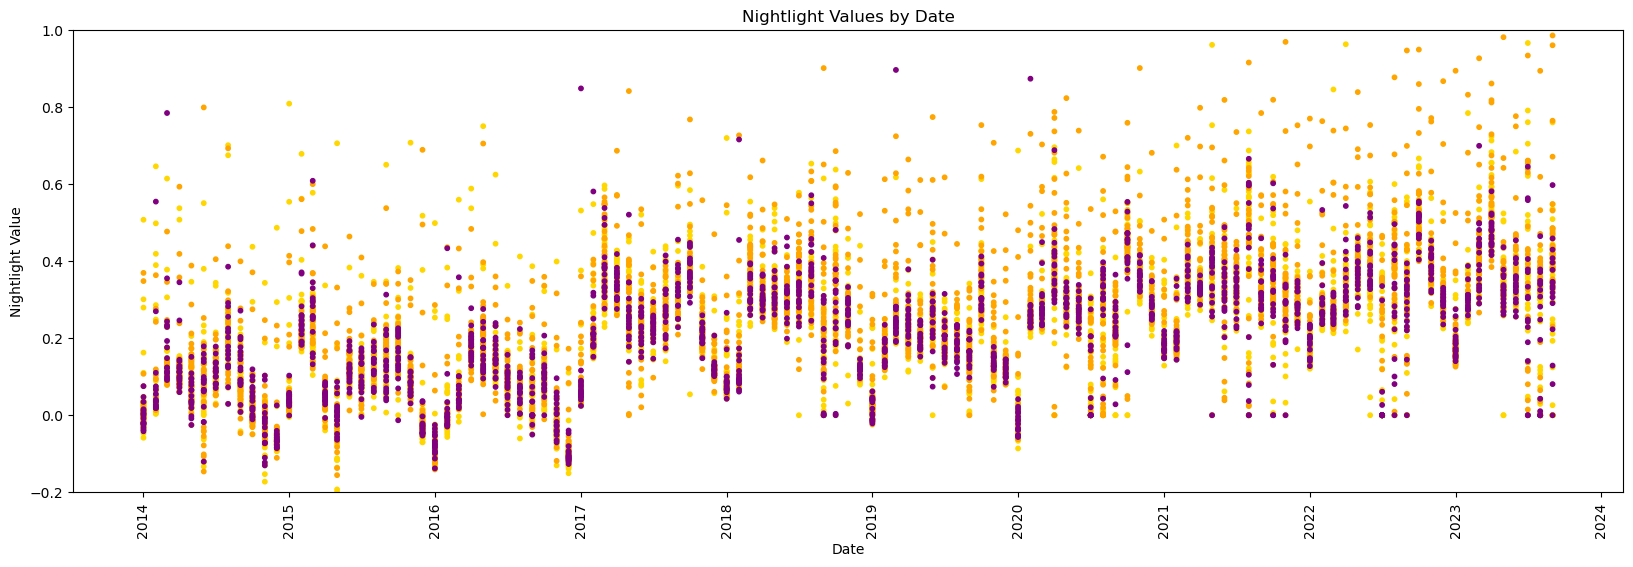

In [51]:
# plot the image values by date with a different color for each site_type
import matplotlib.pyplot as plt

df['image_datetime'] = pd.to_datetime(df['image_date'])

plt.figure(figsize=(20,6))
plt.title('Nightlight Values by Date')
plt.xlabel('Date')
plt.ylabel('Nightlight Value')
# create a scatter plot with different colors for each site type
colors = {'Control': 'gold', 'PowerGen': 'orange', 'CBIL': 'purple'}
plt.scatter(df['image_datetime'], df['image_value'], s=10, c=df['site_type'].apply(lambda x: colors[x]))
# rotate the x axis labels
plt.xticks(rotation=90)
# set the y max to 1.0
plt.ylim(-0.2, 1.0)
plt.show()



In [ ]:
# figure out which sites have image_values of higher than 2
outliers = df[df['image_value'] > 3]

# show the site_names of the outliers
outliers['site_name'].unique()

# filter out these 3 outliers, all sites that are not in ['Pepel', 'Kainkordu', 'Roten']
df = df[~df['site_name'].isin(['Pepel', 'Kainkordu', 'Roten'])]
# TODO look into these outliners!!

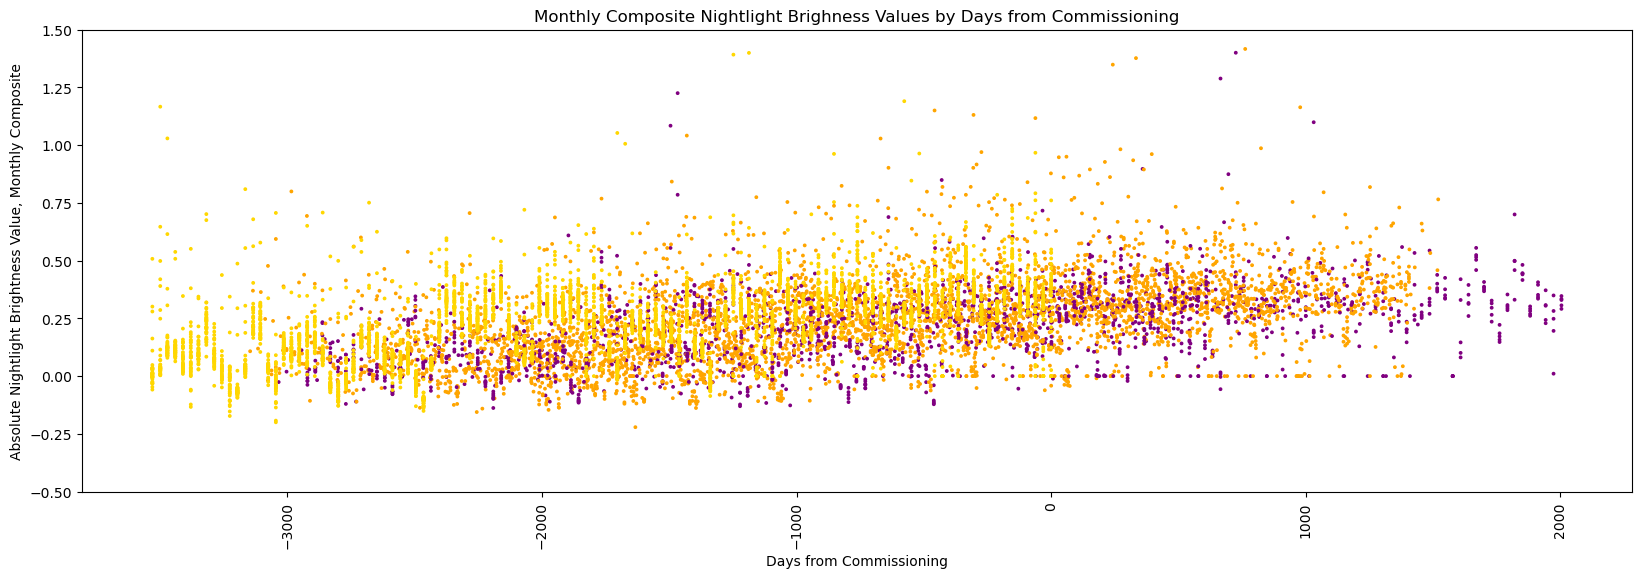

In [54]:
# create column that takes the difference between image_datetime and datetime_commissioned
df.loc[df['site_type'] == 'Control', 'date_commissioned'] = '2023-09-01'
df['datetime_commissioned'] = pd.to_datetime(df['date_commissioned'])
df['image_datetime'] = pd.to_datetime(df['image_date'])
df['time_diff'] = (df['image_datetime'] - df['datetime_commissioned']).dt.days
# print(df)
# plot the image_values by time_diff with a different color for each site_type
plt.figure(figsize=(20,6))
plt.title('Monthly Composite Nightlight Brighness Values by Days from Commissioning')
plt.xlabel('Days from Commissioning')
plt.ylabel('Absolute Nightlight Brightness Value, Monthly Composite')
# create a scatter plot with different colors for each site type
colors = {'Control': 'gold', 'PowerGen': 'orange', 'CBIL': 'purple'}
plt.scatter(df['time_diff'], df['image_value'], s=3, c=df['site_type'].apply(lambda x: colors[x]))
# rotate the x axis labels
plt.xticks(rotation=90)
plt.ylim(-0.5, 1.5)
plt.show()
# set y-axis limit to 1.5


In [ ]:
m

In [ ]:
# TODO run a SARIMAX analysis
#https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

In [ ]:
# print the first few lines of df
df.head()

In [ ]:
# fix the date commmissioned values

# read in sl_cbi_gdf
sl_cbil_gdf = pd.read_csv('data/sl_cbil_gdf.csv')

# print the first few lines
sl_cbil_gdf.head()

In [48]:
# go through every row from df where site_type = "CBIL", and look up the value from site_name in the dataframe sl_cbil_gdf,
# find the value in date_commissioned, and replace date_commissioned with the value from sl_cbil_gdf
for index, row in df[df['site_type'] == 'CBIL'].iterrows():
    # print(row['site_name'], row['date_commissioned'])
    # print(sl_cbil_gdf[sl_cbil_gdf['site'] == row['site_name']]['metadataprojectcod'].values[0])
    df.loc[index, 'date_commissioned'] = sl_cbil_gdf[sl_cbil_gdf['site'] == row['site_name']]['date_commissioned'].values[0]

# check that the date_commissioned values have been updated
df[df['site_type'] == 'CBIL']

# export df again
df.to_csv('data/nightlight_values_v2.csv', index=False)
